In [1]:
import sys
sys.path.append('..')
# reload local packages automatically
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)

# Import packages.
import cvxpy as cp
import numpy as np

import matplotlib.pyplot as plt


from opentn.transformations import create_kitaev_liouvillians, exp_operator_dt, factorize_psd, super2choi
d, N = 2, 4
dim = d**N
Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=N, d=d, gamma=1e-2)
tau = 4
superops_exp = []
for i, op in enumerate([Lvec, Lvec_odd, Lvec_even]):
    if i == 1:
        superops_exp.append(exp_operator_dt(op, tau/2, 'jax'))
    else:
        superops_exp.append(exp_operator_dt(op, tau, 'jax'))
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = superops_exp

X1 = factorize_psd(psd=super2choi(exp_Lvec_odd), tol=1e-12)
X2 = factorize_psd(psd=super2choi(exp_Lvec_even), tol=1e-12)

from opentn.optimization import gds, frobenius_norm, model_Ys, compute_loss
cost_n4, grads_n4, xi_n4 = gds(fn=compute_loss, x0=[X1, X2, X1], iter=int(2e3), loss_fn=frobenius_norm, model=model_Ys, rate=1.5e-9, exact = exp_Lvec, show_cost=False)
print(cost_n4[0])
print(cost_n4[-1])

2.6383007149418305e-07
1.4977787039695335e-07


In [2]:
from opentn.transformations import super2choi, choi_composition
from opentn.optimization import small2zero
from scipy import sparse

# rest of matrices optimized with GSD
X1_gds, X2_gds, X3_gds = xi_n4[-1]
Y1_gds = X1_gds@X1_gds.conj().T
Y2_gds = X2_gds@X2_gds.conj().T
Y3_gds = X3_gds@X3_gds.conj().T

tol = 1e-12

# rhs to which we want to approximate
rhs = np.asarray(super2choi(superop=exp_Lvec, dim=dim))
# srhs = sparse.csr_matrix(rhs) # small2zero was deleted
srhs = sparse.csr_matrix(small2zero(rhs, tol=tol)) # small2zero was deleted
srhs = srhs.astype(np.float64)

from opentn.transformations import link_product_cvxpy
Y1_cvxpy = cp.Variable((dim**2,dim**2), PSD=True)
C2 = choi_composition(small2zero(Y2_gds, tol), small2zero(Y3_gds, tol))
lhs = link_product_cvxpy(C1=Y1_cvxpy, C2=C2, dim=dim, transpose=1, optimization=True)
cost = cp.norm(lhs - srhs, "fro")
prob = cp.Problem(cp.Minimize(cost))
Y1_cvxpy.value = small2zero(Y1_gds, tol=tol).astype(np.float64) 
cost.value

/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/scipy/sparse/_data.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  self.data.astype(dtype, casting=casting, copy=True),
/var/folders/lv/986s3mp97gv9n3rb757bg87m0000gn/T/ipykernel_17592/3121483849.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  Y1_cvxpy.value = small2zero(Y1_gds, tol=tol).astype(np.float64)


1.4977447043603566e-07

In [3]:
print(cp.installed_solvers())

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


In [4]:
mosek_params = {'MSK_DPAR_INTPNT_CO_TOL_REL_GAP':tol, 'MSK_DPAR_INTPNT_CO_TOL_DFEAS':tol, 'MSK_DPAR_INTPNT_CO_TOL_MU_RED':tol, 'MSK_DPAR_INTPNT_CO_TOL_PFEAS':tol}
prob.solve(solver=cp.MOSEK, verbose=True, canon_backend=cp.SCIPY_CANON_BACKEND, mosek_params=mosek_params)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Jul 29 11:16:44 PM: Your problem has 65536 variables, 0 constraints, and 0 parameters.
(CVXPY) Jul 29 11:16:44 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 29 11:16:44 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 29 11:16:44 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 29 11:16:44 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Jul 29 11:16:44 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

9.518657747960218e-08

In [6]:
print(np.linalg.matrix_rank(Y1_cvxpy.value))
print(np.linalg.svd(Y1_cvxpy.value, compute_uv=False)[:24])

247
[1.59601248e+01 1.99251772e-02 1.99251750e-02 2.48854408e-05
 5.53045544e-08 4.73920770e-08 4.47699786e-08 4.04547423e-08
 3.85094399e-08 1.87516898e-08 1.35362344e-08 8.17214997e-09
 3.82400715e-11 3.79075768e-11 3.73607426e-11 3.70695268e-11
 3.70429160e-11 3.70429160e-11 3.70429160e-11 3.70429160e-11
 3.70429160e-11 3.70429160e-11 3.70429160e-11 3.70429160e-11]


In [5]:
mosek_params = {'MSK_DPAR_INTPNT_CO_TOL_REL_GAP':tol, 'MSK_DPAR_INTPNT_CO_TOL_DFEAS':1e-10, 'MSK_DPAR_INTPNT_CO_TOL_MU_RED':tol, 'MSK_DPAR_INTPNT_CO_TOL_PFEAS':tol}
prob.solve(solver=cp.MOSEK, verbose=True, canon_backend=cp.SCIPY_CANON_BACKEND, mosek_params=mosek_params)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Jul 27 12:43:34 PM: Your problem has 65536 variables, 0 constraints, and 0 parameters.
(CVXPY) Jul 27 12:43:34 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 27 12:43:34 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 27 12:43:34 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 27 12:43:34 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Jul 27 12:43:34 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

9.533533139743189e-08

In [13]:
max_idx = 20
for op in [super2choi(exp_Lvec_odd), X1@X1.conj().T, Y1_gds, Y1_cvxpy.value, small2zero(Y1_cvxpy.value, tol=tol)]:
    print(np.linalg.matrix_rank(op, tol=tol))
    print(np.sort(np.linalg.svd(op, compute_uv=False))[::-1][:max_idx])
    print('----')

4
[1.59601247e+01 1.99252079e-02 1.99252079e-02 2.48753638e-05
 9.14980688e-15 8.31005402e-15 8.28778104e-15 7.68898909e-15
 5.05313981e-15 4.30617828e-15 4.16892000e-15 3.72903726e-15
 3.42133722e-15 3.09273854e-15 2.96987622e-15 2.80821003e-15
 2.49762950e-15 2.44857257e-15 2.02103883e-15 2.00628044e-15]
----
4
[1.59601247e+01 1.99252079e-02 1.99252079e-02 2.48753638e-05
 7.95281221e-15 4.45619364e-15 4.15294601e-15 3.74630065e-15
 3.38415367e-15 3.00980011e-15 2.78457911e-15 2.75926410e-15
 2.62875443e-15 2.57327522e-15 2.56723560e-15 2.12727961e-15
 2.10294136e-15 1.91221566e-15 1.87243128e-15 1.76943050e-15]
----
4
[1.59601248e+01 1.99251812e-02 1.99251787e-02 2.48753821e-05
 7.40452593e-15 6.23416821e-15 5.78733966e-15 5.45129161e-15
 5.02854100e-15 4.95731989e-15 4.56542003e-15 4.34589312e-15
 4.19879763e-15 4.02361484e-15 3.80645554e-15 3.57183712e-15
 3.04235402e-15 2.81870941e-15 2.70461589e-15 2.24288391e-15]
----
247
[1.59601248e+01 1.99251772e-02 1.99251750e-02 2.48854408e

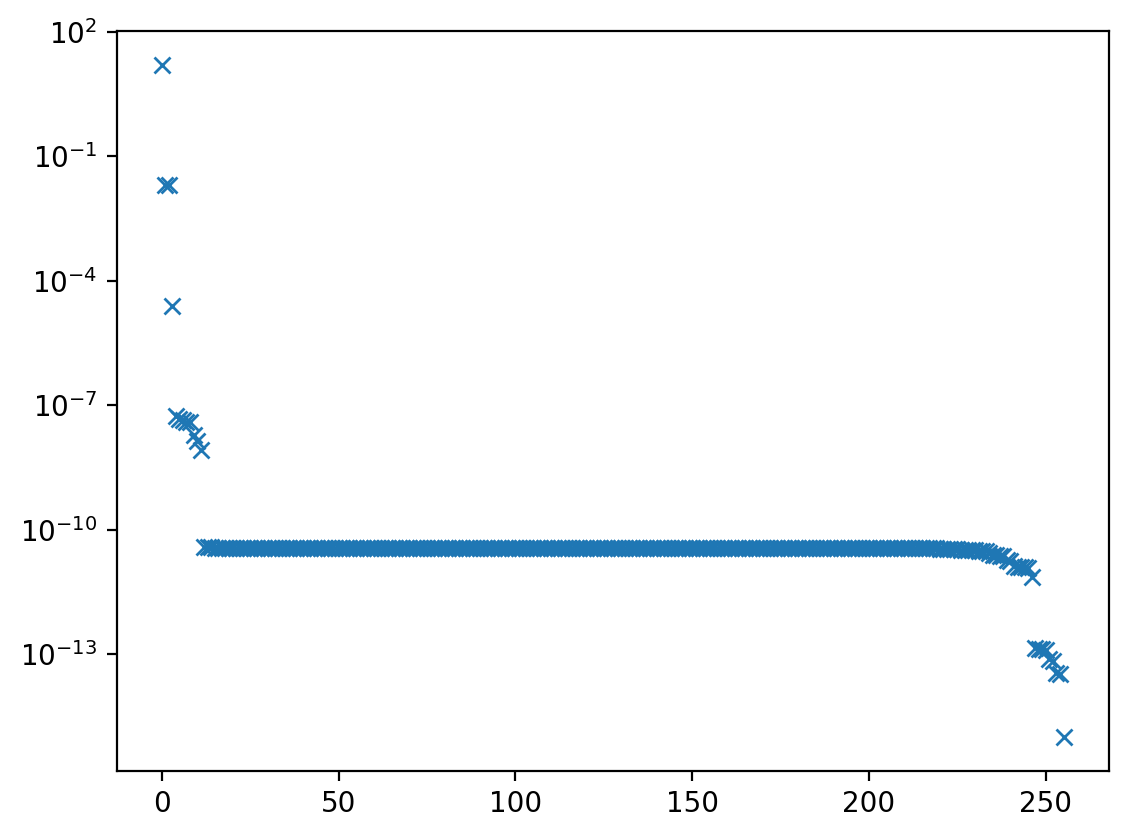

In [10]:
plt.figure(dpi=200)
plt.semilogy(np.linalg.svd(Y1_cvxpy.value, compute_uv=False), 'x')

In [14]:
with open(f'Y1_mosek_warm_gds_eps_{tol}.npy', 'wb') as f:
    np.save(f, Y1_cvxpy.value)